### Load Images

In [1]:
import tensorflow.keras as keras
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16
import xgboost as xgb

In [2]:
def grab_image(img_path):
    img = image.load_img(img_path, target_size=(208, 176))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [3]:
negative_images = np.concatenate( [grab_image('AlzheimersDataset/Negative/neg(%d).jpg'%(i)) for i in range(1, 3201)])
positive_images = np.concatenate( [grab_image('AlzheimersDataset/Positive/pos(%d).jpg'%(i)) for i in range(1, 3201)])

In [5]:
negative_labels = np.zeros(3200, dtype=int)
positive_labels = np.ones(3200, dtype=int)

In [7]:
X = np.concatenate([negative_images, positive_images])
Y = np.concatenate([negative_labels, positive_labels])

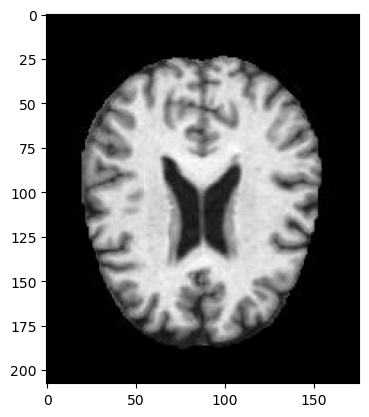

0


In [50]:
plt.imshow(image.array_to_img(X[0,:,:,:]))
plt.show()
print(Y[0])

---

### VGG16

In [14]:
# VGG16 Architecture without fully connected layers, considerding only fully convolutional layers
vgg_model = VGG16(weights = 'imagenet',  include_top = False, input_shape = (208, 176, 3)) 

In [15]:
# make all layers non-trainable
for layer in vgg_model.layers : 
    layer.trainable = False

In [16]:
#vgg_model.summary()

In [17]:
feature_extractor = vgg_model.predict(X)

200/200 [==============================] - 884s 4s/step


In [18]:
# reshape
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_features = features

In [19]:
X_features.shape

(6400, 15360)

#### Save VGG data

In [21]:
df = pd.DataFrame(X_features)

In [26]:
names = []
for x in range(15360):
    names.append('PC%d'%(x+1))

In [27]:
df.columns = names

In [28]:
labels_df = pd.DataFrame(Y)

In [29]:
df_vgg = pd.concat([df, labels_df], axis=1)

In [31]:
df_vgg = df_vgg.rename(columns = {0:'label'})

In [32]:
df_vgg.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15352,PC15353,PC15354,PC15355,PC15356,PC15357,PC15358,PC15359,PC15360,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.336465,0.558180,0.0,0.0,0.0,0.0,0.0,0.057888,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.339931,0.483530,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.155299,0.620120,0.0,0.0,0.0,0.0,0.0,0.162739,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.305931,0.448933,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.317173,0.474593,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0


In [34]:
from pathlib import Path  
filepath = Path('vgg.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_vgg.to_csv(filepath, index=False) 

---

### XGB Classifier

In [35]:
kfold = KFold(n_splits=5, shuffle=True)

In [36]:
acc_per_fold = []
loss_per_fold = []
Y_preds = []
Y_actuals = []

In [39]:
from sklearn import metrics

In [40]:
%%time

fold_no = 1
num_classes = 2

for train, test in kfold.split(X_features,Y):

    model = xgb.XGBClassifier()
        
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(X_features[train], Y[train], verbose=1)
    
    # Generate generalization metrics
    #scores = model.evaluate(X_features[test], Y[test], verbose=0)
    prediction = model.predict(X_features[test])
    accuracy = metrics.accuracy_score(Y[test], prediction)
    print(f'Score for fold {fold_no}: Accuracy of {accuracy}%')
    acc_per_fold.append(accuracy * 100)
    for x in Y[test]:
        Y_actuals = np.append(Y_actuals, x)
    for z in model.predict(X_features[test]):
        Y_preds = np.append(Y_preds, np.argmax(z))
    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: Accuracy of 0.92421875%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: Accuracy of 0.93984375%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: Accuracy of 0.93203125%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: Accuracy of 0.9328125%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: Accuracy of 0.93984375%
Wall time: 15min 57s


In [42]:
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 93.375 (+- 0.5812836011793211)
------------------------------------------------------------------------


In [45]:
Y_actuals

array([0., 0., 0., ..., 1., 1., 1.])

In [46]:
Y_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [47]:
prediction

array([0, 1, 0, ..., 1, 1, 1])

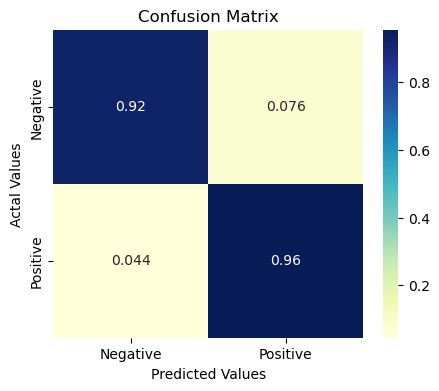

In [48]:
cm = confusion_matrix(Y[test], prediction, normalize = "true")
cm_df = pd.DataFrame(cm,
index = ['Negative','Positive'],
columns = ['Negative','Positive'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig('myCNN2')

In [1]:
FP = 0.076
FN = 0.044
TP = 0.96
TN = 0.92

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Recall: ")
print(TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP)
print("Specificity: ")
print(TNR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Presicion: ")
print(TNR)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("Fall Out: ")
print(FPR)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

Total = FP+FN+TP+TN

# Overall accuracy
ACC = (TP+TN)/Total
print("Accuracy: ")
print(ACC)

# Random accuracy
R_ACC = ((TN+FP)*(TN+FN)+(FN+TP)*(FP+TP))/(Total*Total)

# Kappa
KAPPA = (ACC-R_ACC)/(1-R_ACC)
print("Kappa: ")
print(KAPPA)

F1 = 2 * (TNR * TPR) / (TNR + TPR)
print("F1:")
print(F1)

Recall: 
0.9561752988047808
Specificity: 
0.9236947791164659
Presicion: 
0.9236947791164659
Fall Out: 
0.07630522088353414
Accuracy: 
0.94
Kappa: 
0.8799827175113215
F1:
0.939654438675632


---

### SVM Classifier

In [51]:
kfold = KFold(n_splits=5, shuffle=True)

In [52]:
acc_per_fold = []
loss_per_fold = []
Y_preds = []
Y_actuals = []

In [53]:
from sklearn import svm

In [56]:
%%time

fold_no = 1

for train, test in kfold.split(X_features,Y):

    model = svm.SVC(kernel='poly', degree=3, C=100)
        
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(X_features[train], Y[train])
    
    # Generate generalization metrics
    #scores = model.evaluate(X_features[test], Y[test], verbose=0)
    prediction = model.predict(X_features[test])
    accuracy = metrics.accuracy_score(Y[test], prediction)
    print(f'Score for fold {fold_no}: Accuracy of {accuracy}%')
    acc_per_fold.append(accuracy * 100)
    for x in Y[test]:
        Y_actuals = np.append(Y_actuals, x)
    for z in model.predict(X_features[test]):
        Y_preds = np.append(Y_preds, z)
    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: Accuracy of 0.98203125%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: Accuracy of 0.9828125%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: Accuracy of 0.9828125%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: Accuracy of 0.978125%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: Accuracy of 0.98203125%
Wall time: 10min 20s


In [57]:
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 98.15625 (+- 0.1753901900050285)
------------------------------------------------------------------------


In [58]:
Y_actuals

array([0., 0., 0., ..., 1., 1., 1.])

In [59]:
Y_preds

array([0., 0., 0., ..., 1., 1., 1.])

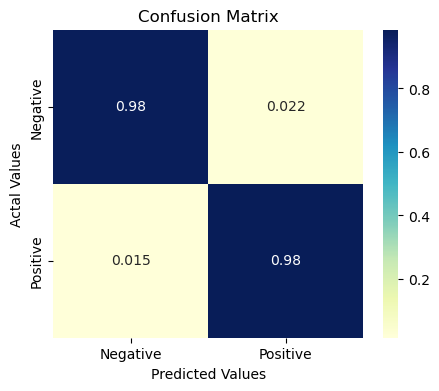

In [61]:
cm = confusion_matrix(Y_actuals, Y_preds, normalize = "true")
cm_df = pd.DataFrame(cm,
index = ['Negative','Positive'],
columns = ['Negative','Positive'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig('myCNN2')

In [63]:
FP = 0.022
FN = 0.015
TP = 0.98
TN = 0.98

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Recall: ")
print(TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP)
print("Specificity: ")
print(TNR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Presicion: ")
print(TNR)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("Fall Out: ")
print(FPR)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

Total = FP+FN+TP+TN

# Overall accuracy
ACC = (TP+TN)/Total
print("Accuracy: ")
print(ACC)

# Random accuracy
R_ACC = ((TN+FP)*(TN+FN)+(FN+TP)*(FP+TP))/(Total*Total)

# Kappa
KAPPA = (ACC-R_ACC)/(1-R_ACC)
print("Kappa: ")
print(KAPPA)

F1 = 2 * (TNR * TPR) / (TNR + TPR)
print("F1:")
print(F1)

Recall: 
0.9849246231155778
Specificity: 
0.9780439121756487
Presicion: 
0.9780439121756487
Fall Out: 
0.021956087824351295
Accuracy: 
0.9814722083124687
Kappa: 
0.9629448719151027
F1:
0.9814722083124686
